# Problem Statement 1 (60 marks)

## The Block Game ##

**Problem Statement:**
A set of wooden blocks of various shapes and colors are sitting on a table. The goal is to build one or more vertical stacks of blocks. The catch is that only one block may be moved at a time: it may either be placed on the table or placed atop another block. Because of this, any blocks that are, at a given time, under another block cannot be moved.

**Initial state :** Given configuration of blocks and a set of block stacks.

**Actions and transitions :** Move block from the top of one stack onto the table or onto the top of another stack.

**Goal :** A given final configuration of the stacks of blocks.

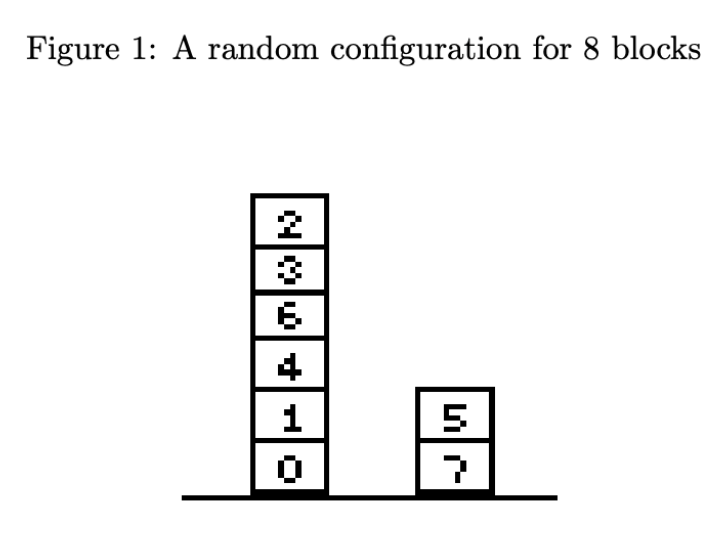


Example: The state from Figure 1 will be repersented as
**state = ((0,1,4,6,3,2),(7,5))**
Action = (1,2) moves the top block from stack 1 to stack 2

Algorithms to compare to find a path :

*   BFS: breadth first search (10 marks)
*   DFS: depth first search  (10 marks)
*   UCS: Uniform-Cost Search  (10 marks)
*   IDS: Iterative Deepning Search (10 marks)
*   A*: A-star seach algorithm [Implement using a different heuristic than the one give in the sample code] (10 marks)
*   IDA\*: Iterative Deepening A\* (10 marks)




There are two performance metrics:

1.   Number of nodes explored
2.   Time taken for execution





E.g:
Number of blocks : 10

Initial : ((2, 4), (0, 5, 6), (3,), (8,), (1, 7, 9))
Goal :  ((1,), (0, 7, 9), (2, 3, 5, 8), (4, 6))


Number of blocks : 15

**Generate initial and goal state using the random_state_generator.py**



# search.py

In [2]:
# search

import heapq

no_of_nodes_explored=0

infinity = float('inf')


def is_number(x):
    """Is x a number?"""
    return hasattr(x, '__int__')


def name(obj):
    """Try to find some reasonable name for the object."""
    return (getattr(obj, 'name', 0) or getattr(obj, '__name__', 0) or
            getattr(getattr(obj, '__class__', 0), '__name__', 0) or
            str(obj))


def print_table(table, header=None, sep='   ', numfmt='{}'):
    """Print a list of lists as a table, so that columns line up nicely.
    header, if specified, will be printed as the first row.
    numfmt is the format for all numbers,
    sep represents the separator between columns."""
    justs = ['rjust' if is_number(x) else 'ljust' for x in table[0]]

    if header:
        table.insert(0, header)

    table = [[numfmt.format(x) if is_number(x) else x for x in row]
             for row in table]

    sizes = list(
        map(lambda seq: max(map(len, seq)),
            list(zip(*[map(str, row) for row in table]))))

    for row in table:
        print(sep.join(getattr(
            str(x), j)(size) for (j, size, x) in zip(justs, sizes, row)))


def memoize(fn, slot=None, maxsize=32):
    """Memoize fn: make it remember the computed value for any argument list.
    If slot is specified, store result in that slot of first argument.
    If slot is false, use lru_cache for caching the values."""
    if slot:
        def memoized_fn(obj, *args):
            if hasattr(obj, slot):
                return getattr(obj, slot)
            else:
                val = fn(obj, *args)
                setattr(obj, slot, val)
                return val
    else:
        @functools.lru_cache(maxsize=maxsize)
        def memoized_fn(*args):
            return fn(*args)

    return memoized_fn


class PriorityQueue:
    """A Queue in which the minimum (or maximum) element (as determined by f and
    order) is returned first.
    If order is 'min', the item with minimum f(x) is
    returned first; if order is 'max', then it is the item with maximum f(x)."""

    def __init__(self, order='min', f=lambda x: x):
        self.heap = []

        if order == 'min':
            self.f = f
        elif order == 'max':  # now item with max f(x)
            self.f = lambda x: -f(x)  # will be popped first
        else:
            raise ValueError("order must be either 'min' or max'.")

    def append(self, item):
        """Insert item at its correct position."""
        heapq.heappush(self.heap, (self.f(item), item))

    def extend(self, items):
        """Insert each item in items at its correct position."""
        for item in items:
            self.heap.append(item)

    def pop(self):
        """Pop and return the item (with min or max f(x) value
        depending on the order."""
        if self.heap:
            return heapq.heappop(self.heap)[1]
        else:
            raise Exception('Trying to pop from empty PriorityQueue.')

    def __len__(self):
        """Return current capacity of PriorityQueue."""
        return len(self.heap)

    def __contains__(self, item):
        """Return True if item in PriorityQueue."""
        return (self.f(item), item) in self.heap

    def __getitem__(self, key):
        for _, item in self.heap:
            if item == key:
                return item

    def __delitem__(self, key):
        """Delete the first occurrence of key."""
        self.heap.remove((self.f(key), key))
        heapq.heapify(self.heap)


class Problem(object):

    """The abstract class for a formal problem."""

    def __init__(self, initial, goal):
        """The constructor specifies the initial state, and possibly a goal
        state, if there is a unique goal."""
        self.initial = initial
        self.goal = goal

    def actions(self, state):
        """Return the actions that can be executed in the given
        state."""
        raise NotImplementedError

    def result(self, state, action):
        """Return the state that results from executing the given
        action in the given state."""
        raise NotImplementedError

    def goal_test(self, state):
        """Return True if the state is a goal."""
        if isinstance(self.goal, list):
            return is_in(state, self.goal)
        else:
            return state == self.goal

    def path_cost(self, c, state1, action, state2):
        """Return the cost of a solution path that arrives at state2 from
           state1 via action, assuming cost c to get up to state1. If the problem
           is such that the path doesn't matter, this function will only look at
           state2. If the path does matter, it will consider c and maybe state1
           and action. The default method costs 1 for every step in the path."""
        return c + 1


class Node:

    """A node in a search tree. Contains a pointer to the parent (the node
    that this is a successor of) and to the actual state for this node. If a state
     is arrived at by two paths, then there are two nodes with
    the same state.  Also includes the action that got us to this state, and
    the total path_cost (also known as g) to reach the node."""

    def __init__(self, state, parent=None, action=None, path_cost=0):
        """Create a search tree Node, derived from a parent by an action."""
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost
        self.depth = 0
        if parent:
            self.depth = parent.depth + 1

    def __repr__(self):
        return "<Node {}>".format(self.state)

    def __lt__(self, node):
        return self.state < node.state

    def expand(self, problem):
        """List the nodes reachable in one step from this node."""
        return [self.child_node(problem, action)
                for action in problem.actions(self.state)]

    def child_node(self, problem, action):
        "Creates and returns a new node based on action result. "
        next_node = problem.result(self.state, action)
        return Node(next_node, self, action,
                    problem.path_cost(self.path_cost, self.state,
                                      action, next_node))

    def solution(self):
        """Return the sequence of actions to go from the root to this node."""
        return [node.action for node in self.path()[1:]]

    def path(self):
        """Return a list of nodes forming the path from the root to this node."""
        node, path_back = self, []
        while node:
            path_back.append(node)
            node = node.parent
        return list(reversed(path_back))

    def __eq__(self, other):
        return isinstance(other, Node) and self.state == other.state

    def __hash__(self):
        return hash(self.state)


def best_first_graph_search(problem, f): #nope
    """Search the nodes with the lowest f scores first.
    You specify the function f(node) that you want to minimize; for example,
    if f is a heuristic estimate to the goal, then we have greedy best
    first search; if f is node.depth then we have breadth-first search.
    There is a subtlety: the line "f = memoize(f, 'f')" means that the f
    values will be cached on the nodes as they are computed. So after doing
    a best first search you can examine the f values of the path returned."""
    global no_of_nodes_explored
    f = memoize(f, 'f')
    node = Node(problem.initial)
    if problem.goal_test(node.state):
        return node
    frontier = PriorityQueue('min', f)
    frontier.append(node)
    explored = set()

    while frontier:
        no_of_nodes_explored+=1
        node = frontier.pop()
        if problem.goal_test(node.state):
            return node
        explored.add(node.state)
        for child in node.expand(problem):
            if child.state not in explored and child not in frontier:
                frontier.append(child)
            elif child in frontier:
                incumbent = frontier[child]
                if f(child) < f(incumbent):
                    del frontier[incumbent]
                    frontier.append(child)

    return None
def idastar(problem,f):
  global no_of_nodes_explored
  f=memoize(f,'f')
  node=Node(problem.initial)
  limit=f(node)
  next_limit=float('inf')
  track=0
  if problem.goal_test(node.state):
    return node
  frontier = PriorityQueue('min',f)
  frontier.append(node)
  explored=set()
  while(next_limit>limit or track==0):
    track=1
    node=Node(problem.initial)
    limit=next_limit
    if problem.goal_test(node.state):
      return node
    frontier = PriorityQueue('min',f)
    frontier.append(node)
    explored=set()
    while frontier:
      no_of_nodes_explored+=1
      node=frontier.pop()
      if problem.goal_test(node.state):
        return node
      explored.add(node.state)
      for child in node.expand(problem):
        if child.state not in explored and child not in frontier:
          if f(child)<=limit:
            frontier.append(child)
          else:
            next_limit=min(next_limit,f(child))
        elif child in frontier:
          incumbent=frontier[child]
          if f(child)<f(incumbent):
            del frontier[incumbent]
            frontier.append(child)
  return None

def ids(problem):
    global no_of_nodes_explored
    level=1
    temp=2
    node=Node(problem.initial)
    explored=set()
    frontier=[]
    if problem.goal_test(node.state):
      return node
    frontier.append((node,1))
    while(temp>level):
      level=temp
      node=Node(problem.initial)
      explored=set()
      frontier=[]
      if problem.goal_test(node.state):
        return node
      frontier.append((node,1))
      while(frontier):
        no_of_nodes_explored+=1
        node,depth=frontier[-1]
        frontier.pop()
        if(depth>level):
          temp=depth
          # level=depth
          # frontier=[]
          # node=Node(problem.initial)
          # if problem.goal_test(node.state):
          #     return node
          # frontier.append((node,1))
          # explored=set()
          continue
        if problem.goal_test(node.state):
          return node
        explored.add(node.state)
        for child in node.expand(problem):
          if child.state not in explored and (child,depth+1) not in frontier:
            frontier.append((child,depth+1))

    return None


def astar_search(problem, h=None):
    """A* search is best-first graph search with f(n) = g(n) + h(n)."""
    h = memoize(h or problem.h, 'h')
    return best_first_graph_search(problem, lambda n: n.path_cost + h(n))

def dfs(problem):
    global no_of_nodes_explored
    node=Node(problem.initial)
    explored=set()
    frontier=[]
    if problem.goal_test(node.state):
      return node
    frontier.append(node)
    while(frontier):
      no_of_nodes_explored+=1
      node=frontier[-1]
      frontier.pop()
      if problem.goal_test(node.state):
        return node
      explored.add(node.state)
      for child in node.expand(problem):
        if child.state not in explored and child not in frontier:
          frontier.append(child)

    return None

def bfSearch(problem):
    global no_of_nodes_explored
    node=Node(problem.initial)
    explored=set()
    frontier=[]
    if problem.goal_test(node.state):
      return node
    frontier.append(node)
    while(frontier):
      no_of_nodes_explored+=1
      node=frontier[0]
      frontier.reverse()
      frontier.pop()
      frontier.reverse()
      if problem.goal_test(node.state):
        return node
      explored.add(node.state)
      for child in node.expand(problem):
        if child.state not in explored and child not in frontier:
          frontier.append(child)

    return None


def ucs(problem):
  return best_first_graph_search(problem,lambda n:n.path_cost)

class InstrumentedProblem(Problem):

    """Delegates to a problem, and keeps statistics."""

    def __init__(self, problem):
        self.problem = problem
        self.succs = self.goal_tests = self.states = 0
        self.found = None

    def actions(self, state):
        self.succs += 1
        return self.problem.actions(state)

    def result(self, state, action):
        self.states += 1
        return self.problem.result(state, action)

    def goal_test(self, state):
        self.goal_tests += 1
        result = self.problem.goal_test(state)
        if result:
            self.found = state
        return result

    def path_cost(self, c, state1, action, state2):
        return self.problem.path_cost(c, state1, action, state2)

    def value(self, state): #nope
        return self.problem.value(state)

    def __getattr__(self, attr): #nope
        return getattr(self.problem, attr)

    def __repr__(self): #nope
        return '<{:4d}/{:4d}/{:4d}/{}>'.format(self.succs, self.goal_tests,
                                               self.states, str(self.found))


# problem.py

In [3]:
# problem

class BlocksWorld(Problem) :
    def __init__(self, initial, goal):
        Problem.__init__(self, initial, goal)
        self.initial = initial
        self.goal = goal

    def result(self, state, action):
        # Method used to compute the resulting state based on a certain action and the current state and return it
        # state - the current state
        # action - action to be taken
        state_list = list(state)
        source_stack = action[0]
        destination_stack = action[1]
        moved_block = 0
        for block in state_list[source_stack]:  # moved_block is the last block in stack
            moved_block = block
        if len(state[source_stack]) != 1:  # If moved_block is not the only block in its stack
            new_stack = []
            for iterator in range(len(state[source_stack])-1):
                new_stack.append(state[source_stack][iterator])  # Copy the other blocks to another stack and
            state_list.append(tuple(new_stack))  # Add them to the final list

        if destination_stack != ' ':   # If the block is moved from one stack to another
            state_list.remove(state[destination_stack])  # delete the old stack
            state_list.append(state[destination_stack] + (moved_block, ))  # and then add the block to it
        else:
            state_list.append((moved_block, ))  # Moving the block down means creating a new stack
            # with only the block in it

        state_list.remove(state[source_stack])  # Delete the old source stack

        state_list.sort(key=lambda stack: len(stack))
        return tuple(state_list)

    def actions(self, state):
        # A method which computes the possible actions to be taken in the current state and returns their list
        # state - the current state
        actions_list = []
        for stack in state:

            for other_stack in state:
                if other_stack != stack:
                    actions_list.append((state.index(stack), state.index(other_stack)))  # An action is represented as a
                    # pair - first element represents the source stack index and the second the destination
                    # stack index for the block movement

            if len(stack) != 1:
                actions_list.append((state.index(stack), ' '))  # A block can be moved down only if it's not
                #  the only block in its stack, then the action would be redundant

        return actions_list

    def goal_test(self, state):
        # A method used to check whether the goal state of the problem has been reached based on the current state
        # state - the current state
        for stack in state:
            if stack not in self.goal:
                return False
        return True


# random_state_generator.py

In [4]:
import random


def state_generator(number_of_blocks):
    # A function which generates a random state for the blocks world problem
    # number_of_blocks - the number of blocks of the problem
    random.seed()  # initialize random seed
    no_of_stacks = random.randint(1, number_of_blocks)  # generate random number of stacks
    state_list = []
    iterator = no_of_stacks

    while iterator >= 0:
        state_list.append([-1, ])  # Add no_of_stacks "non-empty" lists to state_list
        iterator = iterator - 1

    for iterator in range(number_of_blocks):
        stack_number = random.randint(0, no_of_stacks - 1)  # Add a random block to a random stack
        state_list[stack_number].append(iterator)
        if -1 in state_list[stack_number]:
            state_list[stack_number].remove(-1)

    generated_state = []
    for stack in state_list:
        if -1 not in stack:  # Tuples that remain "empty" (contain -1) are not added to the generated_state list
            generated_state.append(tuple(stack))

    state_tuple = tuple(generated_state)  # Transform the list into a tuple
    return state_tuple


# block_world.py

In [5]:
#blocks world

class BlocksWorldH1(BlocksWorld):
    def h(self, node):
        # This heuristic checks whether a block is in the right place
        sum = 0  # The number of blocks that are out of place relative to the goal state.
        for stack in node.state:
            for block in stack:
                for other_stack in self.goal:
                    if block in other_stack:
                        other_position = other_stack.index(block)
                        block_position = stack.index(block)
                        if block_position == 0 or other_position == 0 and \
                                          block_position != other_position or \
                                         stack[block_position-1] != other_stack[other_position-1]:
                                        # blocks under the current block in both states are different
                            sum = sum + 1
                            break
        return sum


class BlocksWorldH2(BlocksWorld):
    def h(self, node):
        # This heuristic counts the number of moves that need to be done
        # in order for every block to reach it correct place
        sum = 0
        for stack in node.state:
            for other_stack in self.goal:
                if stack[0] in other_stack:
                    goal_stack = other_stack
                    break
            for block in stack:
                block_position = stack.index(block)
                if block in goal_stack:
                    if block_position == goal_stack.index(block):
                        continue
                # All blocks above the current block must be moved
                # so that it'll reach its correct place
                sum = sum + len(stack) - block_position
                for iterator in range(block_position, len(stack)):
                    stack_block = stack[iterator]
                    stack_position = stack.index(stack_block)
                    # All blocks below stack_block must be moved
                    # in their correct place, but for every block
                    # stack_block must be moved on the table so we add
                    # each move to the final sum
                    if stack_position != 0:  # If there are blocks below stack_block in the current state
                        for other_stack in self.goal:
                            if stack_block in other_stack:
                                other_position = other_stack.index(stack_block)
                                if other_position != 0:  # If there are blocks below stack_block in the goal state
                                    for iterator_2 in range(0, stack_position):
                                        other_block = stack[iterator_2]
                                        if other_block in other_stack:
                                            if other_stack.index(other_block) < other_position:
                                                sum = sum + 1
                                                break
        return sum


# main.py
Keep the initial state and goal state same for all algorithms for a given number of blocks.




Initial : ((1,), (0, 4), (5,), (3,), (2,))
Goal :  ((4,), (2,), (1,), (3,), (0, 5)) 


Solution for astar search using first heuristic: 


ACTION : STATE : 

Initial state -> ((1,), (0, 4), (5,), (3,), (2,))

Move from 1 down ((1,), (5,), (3,), (2,), (0,), (4,))

Move from 1 to 4 ((1,), (3,), (2,), (4,), (0, 5))





Found in 0.004982948303222656 


The no of nodes explored are 17

------------------------------------------------------------------------


Solution for astar search using second heuristic: 


ACTION : STATE : 

Initial state -> ((1,), (0, 4), (5,), (3,), (2,))

Move from 1 down ((1,), (5,), (3,), (2,), (0,), (4,))

Move from 1 to 4 ((1,), (3,), (2,), (4,), (0, 5))





Found in 0.0009472370147705078 


The no of nodes explored are 3

------------------------------------------------------------------------


Solution for depth first search: 


ACTION : STATE : 

Initial state -> ((1,), (0, 4), (5,), (3,), (2,))

Move from 4 to 3 ((1,), (5,), (0, 4), (3, 2))

Move from 2

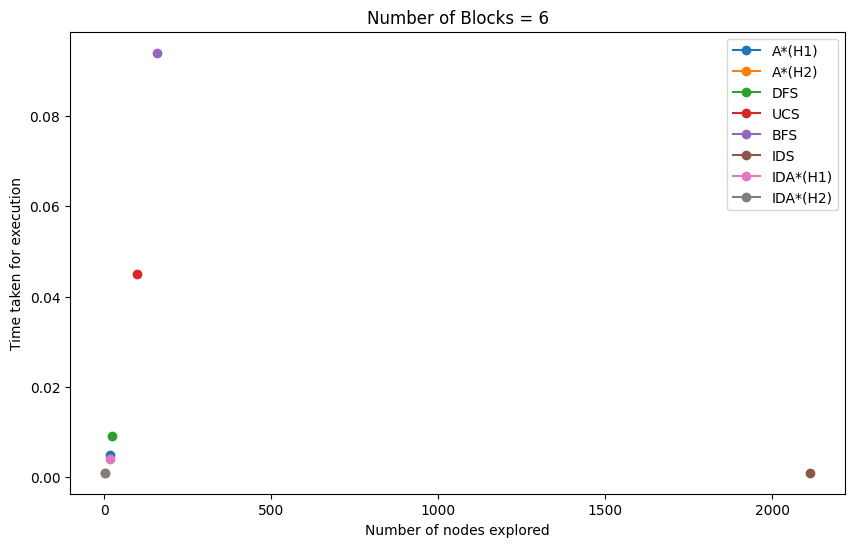

In [6]:
import time

exec_time=[]
nodes_explored=[]

blocks = int(input("Number of blocks : "))
initial_state = state_generator(blocks)  # Generating random states for initial and goal state
goal_state = state_generator(blocks)
print("\n\nInitial :", initial_state)
print("Goal : ", goal_state, "\n\n")

start = time.time()
no_of_nodes_explored=0
problem1 = BlocksWorldH1(initial_state, goal_state) #using the first heuristic

start_time_astar = time.time()
astar = astar_search(problem1)
end_time_astar = time.time()

astar_solution = astar.solution()
astar_path = astar.path()


# Print each state and the action that results to it for both searchers

print("Solution for astar search using first heuristic: \n\n")

print("ACTION : STATE : \n")

initial = astar_path[0].state
print("Initial state -> {0}\n".format(initial))

for iterator in range(1, len(astar_path)):
    state = astar_path[iterator].state
    action = astar_solution[iterator - 1]

    if action[1] != ' ':
        print("Move from {0} to {1} {2}\n".format(action[0], action[1], state))
    else:
        print("Move from {0} down {1}\n".format(action[0], state))
print("\n\n\n")

print("Found in {0} \n\n".format(end_time_astar - start_time_astar))  # Execution time for A* search
print(f"The no of nodes explored are {no_of_nodes_explored}")
print("\n------------------------------------------------------------------------\n\n")
exec_time.append(end_time_astar - start_time_astar)
nodes_explored.append(no_of_nodes_explored)
#my code starts here
# A star using the second heuristic function
start = time.time()
no_of_nodes_explored=0
problem1 = BlocksWorldH2(initial_state, goal_state) #using the first heuristic

start_time_astar = time.time()
astar = astar_search(problem1)
end_time_astar = time.time()

astar_solution = astar.solution()
astar_path = astar.path()


# Print each state and the action that results to it for both searchers

print("Solution for astar search using second heuristic: \n\n")

print("ACTION : STATE : \n")

initial = astar_path[0].state
print("Initial state -> {0}\n".format(initial))

for iterator in range(1, len(astar_path)):
    state = astar_path[iterator].state
    action = astar_solution[iterator - 1]

    if action[1] != ' ':
        print("Move from {0} to {1} {2}\n".format(action[0], action[1], state))
    else:
        print("Move from {0} down {1}\n".format(action[0], state))
print("\n\n\n")

print("Found in {0} \n\n".format(end_time_astar - start_time_astar))  # Execution time for A* search
print(f"The no of nodes explored are {no_of_nodes_explored}")
print("\n------------------------------------------------------------------------\n\n")
exec_time.append(end_time_astar - start_time_astar)
nodes_explored.append(no_of_nodes_explored)


#Depth first search
start = time.time()
no_of_nodes_explored=0
problem1 = BlocksWorldH1(initial_state, goal_state) #using the second heuristic
#h = memoize(problem1.h, 'h')
start_time_dfs = time.time()
dpfs = dfs(problem1)
end_time_dfs = time.time()

dfs_solution = dpfs.solution()
dfs_path = dpfs.path()


# Print each state and the action that results to it for both searchers

print("Solution for depth first search: \n\n")

print("ACTION : STATE : \n")

initial = dfs_path[0].state
print("Initial state -> {0}\n".format(initial))

for iterator in range(1, len(dfs_path)):
    state = dfs_path[iterator].state
    action = dfs_solution[iterator - 1]

    if action[1] != ' ':
        print("Move from {0} to {1} {2}\n".format(action[0], action[1], state))
    else:
        print("Move from {0} down {1}\n".format(action[0], state))
print("\n\n\n")

print("Found in {0} \n\n".format(end_time_dfs - start_time_dfs))  # Execution time for bfs search
print(f"The no of nodes explored are {no_of_nodes_explored}")
print("\n------------------------------------------------------------------------\n\n")
exec_time.append(end_time_dfs - start_time_dfs)
nodes_explored.append(no_of_nodes_explored)
# Uniform cost search
start = time.time()
no_of_nodes_explored=0
problem1 = BlocksWorldH1(initial_state, goal_state) #using the first heuristic
h = memoize(problem1.h, 'h')
start_time_ucs = time.time()
ucs_ = ucs(problem1)
end_time_ucs = time.time()

ucs_solution = ucs_.solution()
ucs_path = ucs_.path()


# Print each state and the action that results to it for both searchers

print("Solution for uniform cost search: \n\n")

print("ACTION : STATE : \n")

initial = ucs_path[0].state
print("Initial state -> {0}\n".format(initial))

for iterator in range(1, len(ucs_path)):
    state = ucs_path[iterator].state
    action = ucs_solution[iterator - 1]

    if action[1] != ' ':
        print("Move from {0} to {1} {2}\n".format(action[0], action[1], state))
    else:
        print("Move from {0} down {1}\n".format(action[0], state))
print("\n\n\n")

print("Found in {0} \n\n".format(end_time_ucs - start_time_ucs))  # Execution time for ucs search
print(f"The no of nodes explored are {no_of_nodes_explored}")
print("\n------------------------------------------------------------------------\n\n")
exec_time.append(end_time_ucs - start_time_ucs)
nodes_explored.append(no_of_nodes_explored)
#Breadth first search using first heuristic
start = time.time()
no_of_nodes_explored=0
problem1 = BlocksWorldH1(initial_state, goal_state) #using the first heuristic
h = memoize(problem1.h, 'h')
start_time_bfs = time.time()
bfs_ = bfSearch(problem1)
end_time_bfs = time.time()

bfs_solution = bfs_.solution()
bfs_path = bfs_.path()


# Print each state and the action that results to it for both searchers

print("Solution for breadth first search: \n\n")

print("ACTION : STATE : \n")

initial = bfs_path[0].state
print("Initial state -> {0}\n".format(initial))

for iterator in range(1, len(bfs_path)):
    state = bfs_path[iterator].state
    action = bfs_solution[iterator - 1]

    if action[1] != ' ':
        print("Move from {0} to {1} {2}\n".format(action[0], action[1], state))
    else:
        print("Move from {0} down {1}\n".format(action[0], state))
print("\n\n\n")

print("Found in {0} \n\n".format(end_time_bfs - start_time_bfs))  # Execution time for bfs search
print(f"The no of nodes explored are {no_of_nodes_explored}")
print("\n------------------------------------------------------------------------\n\n")
exec_time.append(end_time_bfs - start_time_bfs)
nodes_explored.append(no_of_nodes_explored)
# IDS
start = time.time()
no_of_nodes_explored=0
problem1 = BlocksWorldH1(initial_state, goal_state) #using the first heuristic
h = memoize(problem1.h, 'h')
start_time_ids = time.time()
ids_ = ids(problem1)
end_time_ids = time.time()

ids_solution = ids_.solution()
ids_path = ids_.path()


# Print each state and the action that results to it for both searchers

print("Solution for Iterative deepening search: \n\n")

print("ACTION : STATE : \n")

initial = ids_path[0].state
print("Initial state -> {0}\n".format(initial))

for iterator in range(1, len(bfs_path)):
    state = ids_path[iterator].state
    action = ids_solution[iterator - 1]

    if action[1] != ' ':
        print("Move from {0} to {1} {2}\n".format(action[0], action[1], state))
    else:
        print("Move from {0} down {1}\n".format(action[0], state))
print("\n\n\n")

print("Found in {0} \n\n".format(end_time_ids - start_time_ids))  # Execution time for ids search
print(f"The no of nodes explored are {no_of_nodes_explored}")
print("\n------------------------------------------------------------------------\n\n")
exec_time.append(end_time_astar - start_time_astar)
nodes_explored.append(no_of_nodes_explored)

#IDA* search using first heuristic
start = time.time()
no_of_nodes_explored=0
problem1 = BlocksWorldH1(initial_state, goal_state) #using the first heuristic
h = memoize(problem1.h, 'h')
start_time_ida = time.time()
ida = idastar(problem1,lambda n: n.path_cost + h(n))
end_time_ida = time.time()

ida_solution = ida.solution()
ida_path = ida.path()


# Print each state and the action that results to it for both searchers

print("Solution for IDA* search using first heuristic: \n\n")

print("ACTION : STATE : \n")

initial = ida_path[0].state
print("Initial state -> {0}\n".format(initial))

for iterator in range(1, len(ida_path)):
    state = ida_path[iterator].state
    action = ida_solution[iterator - 1]

    if action[1] != ' ':
        print("Move from {0} to {1} {2}\n".format(action[0], action[1], state))
    else:
        print("Move from {0} down {1}\n".format(action[0], state))
print("\n\n\n")

print("Found in {0} \n\n".format(end_time_ida - start_time_ida))  # Execution time for bfs search
print(f"The no of nodes explored are {no_of_nodes_explored}")
print("\n------------------------------------------------------------------------\n\n")
exec_time.append(end_time_ida - start_time_ida)
nodes_explored.append(no_of_nodes_explored)

#IDA* search using second heuristic
start = time.time()
no_of_nodes_explored=0
problem1 = BlocksWorldH2(initial_state, goal_state) #using the first heuristic
h = memoize(problem1.h, 'h')
start_time_ida = time.time()
ida = idastar(problem1,lambda n: n.path_cost + h(n))
end_time_ida = time.time()

ida_solution = ida.solution()
ida_path = ida.path()


# Print each state and the action that results to it for both searchers

print("Solution for IDA* search using second heuristic: \n\n")

print("ACTION : STATE : \n")

initial = ida_path[0].state
print("Initial state -> {0}\n".format(initial))

for iterator in range(1, len(ida_path)):
    state = ida_path[iterator].state
    action = ida_solution[iterator - 1]

    if action[1] != ' ':
        print("Move from {0} to {1} {2}\n".format(action[0], action[1], state))
    else:
        print("Move from {0} down {1}\n".format(action[0], state))
print("\n\n\n")

print("Found in {0} \n\n".format(end_time_ida - start_time_ida))  # Execution time for bfs search
print(f"The no of nodes explored are {no_of_nodes_explored}")
print("\n------------------------------------------------------------------------\n\n")
exec_time.append(end_time_ida - start_time_ida)
nodes_explored.append(no_of_nodes_explored)
#my code ends here
import matplotlib.pyplot as plt
x_axis=["A*(H1)","A*(H2)","DFS","UCS","BFS","IDS","IDA*(H1)","IDA*(H2)"]
plt.figure(figsize=(10,6))
for i,algo in enumerate(x_axis):
  plt.plot(nodes_explored[i],exec_time[i],marker="o",label=algo)

plt.xlabel("Number of nodes explored")
plt.ylabel("Time taken for execution")
plt.title(f"Number of Blocks = {blocks}")

plt.legend()

plt.show()